# Финальный эксперимент, который позволил получить хорошую метрику. 
## Идея эксперимента: обьединить новую архитектуру с преобразованиями из эксперимента 1

## Первоначальный анализ данных и их обработка

### Установка библиотек

In [1]:
# Стандартные библиотеки
import ast
from pathlib import Path
import joblib

# Научные вычисления и данные
import numpy as np
import pandas as pd
from numpy.linalg import norm

# Машинное обучение и обработка данных
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Глубокое обучение (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

# Визуализация
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Инструменты прогресса
from tqdm import tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


# Загрузка датасета
Здесь ничего не менял по сравнению с ноутбуком lab2.ipynb

In [3]:
# Загружаем основные файлы
df = pd.read_csv('dataset/data.csv')
df_genre = pd.read_csv('dataset/data_w_genres.csv')

# В data.csv артисты записаны как "['Artist1', 'Artist2']".
# Берем первого (основного) артиста для мэтчинга.
df['main_artist'] = df['artists'].apply(lambda x: ast.literal_eval(x)[0])

# Объединяем с данными о жанрах
df = pd.merge(df, df_genre[['artists', 'genres']], left_on='main_artist', right_on='artists', how='left')
df.drop('artists_y', axis=1, inplace=True)
df.rename(columns={'artists_x': 'artists'}, inplace=True)

# Заполняем пустые жанры заглушкой
df['genres'] = df['genres'].fillna("['unknown']")

In [4]:
df.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'main_artist', 'genres'],
      dtype='object')

In [5]:
df.head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,main_artist,genres
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,Sergei Rachmaninoff,"['classical', 'post-romantic era', 'russian ro..."
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,Dennis Day,[]
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,[]
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,Frank Parker,[]
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,Phil Regan,[]


In [6]:
# 1) Создаём псевдо-плейлисты по основному артисту и эпохе (2-летний интервал)
df_filtered = df.copy()
df_filtered['epoch'] = (df_filtered['year'] // 2) * 2
df_filtered['playlist_id'] = df_filtered['main_artist'].astype(str) + "_" + df_filtered['epoch'].astype(str)

# 2) Фильтрация по размеру плейлиста
MIN_TRACKS_PER_PLAYLIST = 8 # Минимальное количество треков в плейлисте для оценки
pl_counts = df_filtered['playlist_id'].value_counts()
keep_pl = pl_counts[pl_counts >= MIN_TRACKS_PER_PLAYLIST].index
df_filtered = df_filtered[df_filtered['playlist_id'].isin(keep_pl)].copy()

print(f"Количество песен после фильтрации: {len(df_filtered)}")
print(f"Количество уникальных 'плейлистов' для оценки: {df_filtered['playlist_id'].nunique()}")

Количество песен после фильтрации: 97212
Количество уникальных 'плейлистов' для оценки: 5095


In [7]:
features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
            'speechiness', 'tempo']
# Разделяем по плейлистам, чтобы тест был "честным"
unique_playlists = df_filtered['playlist_id'].unique()
train_pl, test_pl = train_test_split(unique_playlists, test_size=0.2, random_state=42)

df_train = df_filtered[df_filtered['playlist_id'].isin(train_pl)]
df_test = df_filtered[df_filtered['playlist_id'].isin(test_pl)]

# Нормализация [0, 1] для автоинкодера
mm_scaler = MinMaxScaler()
X_train = mm_scaler.fit_transform(df_train[features])
X_test = mm_scaler.transform(df_test[features])

# Сохранение файлов

train_test_dir = Path("experimenter_folder/train_test_npy_and_metadata")
train_test_dir.mkdir(parents=True, exist_ok=True)


np.save(train_test_dir / 'X_train.npy', X_train)
np.save(train_test_dir / 'X_test.npy', X_test)

# Сохранем scaler для последующего embed/recommend
joblib.dump(mm_scaler, train_test_dir / "scaler.joblib")

df_train.to_csv(train_test_dir / 'metadata_train.csv', index=False)
df_test.to_csv(train_test_dir / 'metadata_test.csv', index=False)

## Обучение нейросети и её настройка

Загрузка предобработанных данных

In [8]:
train_test_dir = Path("experimenter_folder/train_test_npy_and_metadata")
train_test_dir.mkdir(parents=True, exist_ok=True)

train_data_slice = 2000000 # если нужно быстро проверить модель, то ставим меньшее число, например 10к

X_train_full = np.load(train_test_dir / "X_train.npy")[:train_data_slice]
X_test = np.load(train_test_dir / 'X_test.npy')

metadata_train_full = pd.read_csv(train_test_dir / "metadata_train.csv")[:train_data_slice]
metadata_test = pd.read_csv(train_test_dir / "metadata_test.csv")

print("Train shape:", X_train_full.shape)
print("Train playlists:", metadata_train_full['playlist_id'].nunique())
print("Test shape:", X_test.shape)
print("Test playlists:", metadata_test['playlist_id'].nunique())

Train shape: (76827, 9)
Train playlists: 4076
Test shape: (20385, 9)
Test playlists: 1019


In [9]:
unique_playlists = metadata_train_full['playlist_id'].unique()
train_pl, val_pl = train_test_split(
    unique_playlists, test_size=0.2, random_state=42
)

train_mask = metadata_train_full['playlist_id'].isin(train_pl)
val_mask = metadata_train_full['playlist_id'].isin(val_pl)

X_train = X_train_full[train_mask.values]
X_val = X_train_full[val_mask.values]

metadata_train = metadata_train_full[train_mask].reset_index(drop=True)
metadata_val = metadata_train_full[val_mask].reset_index(drop=True)

print("Train tracks:", len(X_train))
print("Val tracks:", len(X_val))
print("Val playlists:", metadata_val['playlist_id'].nunique())

Train tracks: 59741
Val tracks: 17086
Val playlists: 816


In [10]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (norm(a) * norm(b) + 1e-8)


def recall_at_k(recommended, hidden, k):
    return len(set(recommended[:k]) & hidden) / len(hidden)


def ndcg_at_k(recommended, hidden, k):
    dcg = 0.0
    for i, idx in enumerate(recommended[:k]):
        if idx in hidden:
            dcg += 1 / np.log2(i + 2)

    ideal = sum(1 / np.log2(i + 2) for i in range(min(len(hidden), k)))
    return dcg / ideal if ideal > 0 else 0.0


def evaluate_playlist_continuation(df, K=10, hide_frac=0.3):
    recalls, ndcgs = [], []

    for pid, group in df.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group.index.to_numpy()
        np.random.shuffle(indices)

        split = int(len(indices) * (1 - hide_frac))
        known_idx = indices[:split]
        hidden_idx = indices[split:]

        known_z = np.vstack(df.loc[known_idx, 'z'])
        hidden = set(hidden_idx)

        playlist_vec = known_z.mean(axis=0)

        scores = []
        for idx, z in zip(df.index, df['z']):
            scores.append((idx, cosine_similarity(playlist_vec, z)))

        scores.sort(key=lambda x: x[1], reverse=True)
        recommended = [idx for idx, _ in scores if idx not in known_idx]

        recalls.append(recall_at_k(recommended, hidden, K))
        ndcgs.append(ndcg_at_k(recommended, hidden, K))

    return np.mean(recalls), np.mean(ndcgs)


def supcon_loss(z, playlist_ids, tau=0.1):
    """
    playlist_ids может быть:
      - torch.Tensor/np.array чисел
      - list/np.array строк
      - list mixed (нежелательно, но обработаем)
    """
    device = z.device

    # 1) Приводим playlist_ids к "плоскому" python-списку
    if torch.is_tensor(playlist_ids):
        pid_list = playlist_ids.detach().cpu().tolist()
    else:
        pid_list = list(playlist_ids)

    # 2) Если это строки (или нечисловые), кодируем в int внутри батча
    #    (достаточно для SupCon, потому что сравнение нужно только внутри батча)
    if len(pid_list) == 0:
        return torch.tensor(0.0, device=device)

    first = pid_list[0]
    if isinstance(first, (str, bytes)) or any(isinstance(p, (str, bytes)) for p in pid_list):
        mapping = {}
        encoded = []
        nxt = 0
        for p in pid_list:
            if p not in mapping:
                mapping[p] = nxt
                nxt += 1
            encoded.append(mapping[p])
        pids = torch.tensor(encoded, device=device, dtype=torch.long)
    else:
        # Числовые
        pids = torch.tensor(pid_list, device=device, dtype=torch.long)

    # 3) SupCon / InfoNCE
    logits = (z @ z.T) / tau
    logits = logits - logits.max(dim=1, keepdim=True).values.detach()

    n = z.size(0)
    mask_offdiag = ~torch.eye(n, dtype=torch.bool, device=device)
    pos_mask = (pids.unsqueeze(0) == pids.unsqueeze(1)) & mask_offdiag

    exp_logits = torch.exp(logits) * mask_offdiag
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)

    pos_cnt = pos_mask.sum(dim=1)
    loss_vec = -(log_prob * pos_mask).sum(dim=1) / (pos_cnt + 1e-12)

    valid = pos_cnt > 0
    return loss_vec[valid].mean() if valid.any() else torch.tensor(0.0, device=device)

In [11]:
# --- Инициализация инструментов (Глобально) ---

# 1. Для аудио-фич (PCA) - убираем корреляцию, оставляем суть звука
pca = PCA(n_components=7)
pca_scaler = MinMaxScaler()

# 2. Жанры удалены из инициализации

# 3. Для дополнительных признаков (Year, Pop, Duration и т.д.)
extra_scaler = MinMaxScaler()

def get_circle_of_fifths_coords(keys):
    # Маппинг в квинтовый круг (математическая трансформация, скалер не нужен)
    steps = (keys * 7) % 12
    angle = 2 * np.pi * steps / 12
    return np.sin(angle), np.cos(angle)

def prepare_smart_features(X_orig, df_metadata, is_train=True):
    # 1. PCA Audio
    if is_train:
        X_pca = pca.fit_transform(X_orig)
        X_pca_scaled = pca_scaler.fit_transform(X_pca)
    else:
        X_pca = pca.transform(X_orig)
        X_pca_scaled = pca_scaler.transform(X_pca)

    # 2. Умный Key (Circle of Fifths) - координаты всегда в [-1, 1]
    k_sin, k_cos = get_circle_of_fifths_coords(df_metadata['key'].values)
    key_coords = np.column_stack([k_sin, k_cos])

    # 3. Блок жанров (SVD) УДАЛЕН для предотвращения "паспортной" утечки

    # 4. Стандартные признаки + Длительность
    extra_cols = ['year', 'popularity', 'explicit', 'mode']
    extra_data = df_metadata[extra_cols].values
    duration = np.log1p(df_metadata['duration_ms'].values).reshape(-1, 1)
    final_extra_raw = np.hstack([extra_data, duration])

    if is_train:
        final_extra_scaled = extra_scaler.fit_transform(final_extra_raw)
    else:
        final_extra_scaled = extra_scaler.transform(final_extra_raw)

    # ИТОГ: 7(PCA) + 2(Key) + 5(Extra) = 14 признаков
    # Мы убрали 5 признаков SVD-жанров
    X_final = np.hstack([X_pca_scaled, key_coords, final_extra_scaled])
    
    return X_final.astype(np.float32)

# ПРИМЕНЕНИЕ 

# Обучаем инструменты на тренировочном наборе
X_train_smart = prepare_smart_features(X_train, metadata_train, is_train=True)

# Применяем к валидации и тесту
X_val_smart = prepare_smart_features(X_val, metadata_val, is_train=False)
X_test_smart = prepare_smart_features(X_test, metadata_test, is_train=False)

print(f"Размерность признаков (Blind Mode): {X_train_smart.shape[1]}") # Ожидаем 14

Размерность признаков (Blind Mode): 14


In [12]:
def evaluate_knn_baseline_fast(df, X, K=10, hide_frac=0.3):
    """
    Векторизованная версия оценки kNN бейзлайна.
    Работает значительно быстрее за счет использования матричного умножения.
    """
    # 1. Подготовка данных: приводим X к numpy и нормализуем для косинусного сходства
    X = np.array(X)
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
    X_normalized = X / norms
    
    # Работаем с копией df и сбрасываем индексы для соответствия с матрицей X
    df_eval = df.copy().reset_index(drop=True)
    df_eval['row_idx'] = np.arange(len(df_eval))
    
    recalls, ndcgs = [], []

    # Предварительно рассчитываем логарифмические веса для nDCG
    log_weights = 1.0 / np.log2(np.arange(2, K + 2))
    idcg_perfect = np.sum(log_weights) # Идеальный DCG (если все скрытые в топе)

    # Цикл по плейлистам (от этого цикла не уйти, но внутри всё векторизовано)
    for pid, group in df_eval.groupby('playlist_id'):
        if len(group) < 5:
            continue

        indices = group['row_idx'].values
        np.random.shuffle(indices)

        # Сплит на известные и скрытые
        split = int(len(indices) * (1 - hide_frac))
        known_idx = indices[:split]
        hidden_idx = set(indices[split:])
        
        if not hidden_idx:
            continue

        # 2. Вычисляем центроид плейлиста (среднее известных векторов)
        playlist_vec = X_normalized[known_idx].mean(axis=0)
        # Ре-нормализуем центроид
        playlist_vec /= (np.linalg.norm(playlist_vec) + 1e-8)

        # 3. Считаем косинусное сходство СО ВСЕМИ треками одной операцией
        # (Матрица * Вектор = Вектор оценок)
        scores = X_normalized @ playlist_vec

        # Исключаем из выдачи треки, которые уже "известны" (ставим им мин. балл)
        scores[known_idx] = -1.0

        # 4. Получаем Топ-К индексов (наиболее похожих)
        # argsort возвращает индексы в порядке возрастания, берем последние K
        top_k_indices = np.argsort(scores)[-K:][::-1]

        # 5. Расчет метрик
        # Recall
        hits = [idx for idx in top_k_indices if idx in hidden_idx]
        recalls.append(len(hits) / len(hidden_idx))
        
        # nDCG
        dcg = 0.0
        for i, idx in enumerate(top_k_indices):
            if idx in hidden_idx:
                dcg += log_weights[i]
        
        # Нормализуем DCG (идеальный случай зависит от количества скрытых элементов)
        actual_idcg = np.sum(log_weights[:min(len(hidden_idx), K)])
        ndcgs.append(dcg / actual_idcg if actual_idcg > 0 else 0)

    return np.mean(recalls), np.mean(ndcgs)

# Использование:
baseline_recall, baseline_ndcg = evaluate_knn_baseline_fast(
    metadata_val,
    X_val_smart, # Используем твои "умные" признаки
    K=10
)

print(f"kNN baseline (Fast) Recall@10: {baseline_recall:.4f}")
print(f"kNN baseline (Fast) nDCG@10: {baseline_ndcg:.4f}")

kNN baseline (Fast) Recall@10: 0.0285
kNN baseline (Fast) nDCG@10: 0.0288


## Обогащение признаков:

In [13]:
class TracksWithPlaylistDataset(Dataset):
    def __init__(self, X, playlist_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.playlist_ids = np.array(playlist_ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.playlist_ids[idx]


train_ds = TracksWithPlaylistDataset(
    X_train_smart,
    metadata_train['playlist_id'].values
)

BATCH_PLAYLISTS = 60
SAMPLES_PER_PLAYLIST = 4
BATCHES_PER_EPOCH = 370  # Примерно len(train)/(Batch_Playlists * Samples_per_Playlist)

class BalancedBatchSampler(Sampler):
    def __init__(self, playlist_ids, n_playlists, n_samples, n_batches, seed=42):
        self.playlist_ids = np.asarray(playlist_ids)
        self.n_playlists = n_playlists
        self.n_samples = n_samples
        self.n_batches = n_batches
        self.rng = np.random.default_rng(seed)

        self.pid_to_indices = {}
        for i, pid in enumerate(self.playlist_ids):
            self.pid_to_indices.setdefault(pid, []).append(i)
        self.pids = np.array(list(self.pid_to_indices.keys()))

    def __len__(self):
        return self.n_batches

    def __iter__(self):
        for _ in range(self.n_batches):
            batch_pids = self.rng.choice(self.pids, size=self.n_playlists, replace=False)
            batch = []
            for pid in batch_pids:
                idx = self.pid_to_indices[pid]
                chosen = self.rng.choice(idx, size=self.n_samples, replace=(len(idx) < self.n_samples))
                batch.extend(chosen.tolist())
            yield batch

train_sampler = BalancedBatchSampler(
    metadata_train['playlist_id'].values,
    n_playlists=BATCH_PLAYLISTS,
    n_samples=SAMPLES_PER_PLAYLIST,
    n_batches=BATCHES_PER_EPOCH,
    seed=42
)

train_loader = DataLoader(train_ds, batch_sampler=train_sampler)

In [14]:
class TrackEmbedder(nn.Module):
    def __init__(self, input_dim=9, emb_dim=32, dropout=0.10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.GELU(),
            nn.Linear(32, emb_dim),
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

model = TrackEmbedder(input_dim=X_train_smart.shape[1], emb_dim=32, dropout=0.10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def total_loss(x, x_hat, z, playlist_ids):
    recon = criterion(x_hat, x)
    contrast = supcon_loss(z, playlist_ids)
    return recon + lambda_contrast * contrast, recon, contrast


lambda_contrast = 0.1
num_epochs = 15

epoch_loss = []
epoch_recon = []
epoch_contrast = []
val_recalls = []
val_ndcgs = []

Using device: cuda


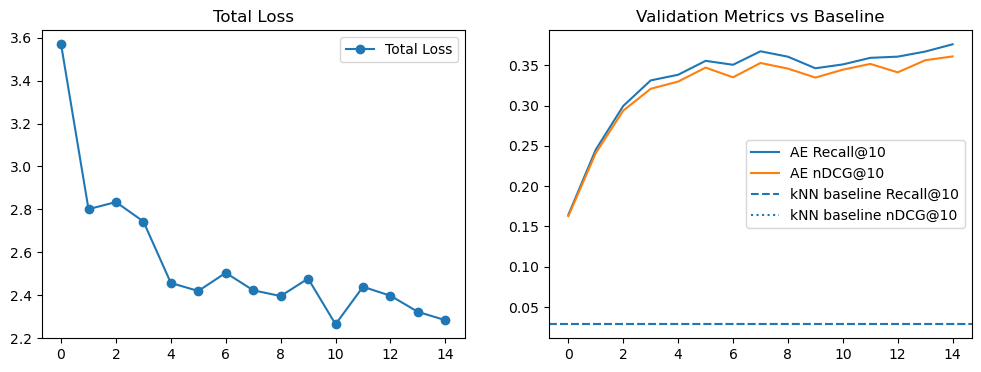

In [16]:
for epoch in range(num_epochs):
    # Train
    model.train()

    for x, pid in train_loader:
        x = x.to(device)

        optimizer.zero_grad()

        z = model(x)
        loss = supcon_loss(z, pid, tau=0.07)

        loss.backward()
        optimizer.step()

    epoch_loss.append(loss.item())

    # Validation metric
    model.eval()
    with torch.no_grad():
        Z_val = model(torch.tensor(X_val_smart, device=device)).cpu().numpy()

    metadata_val['z'] = list(Z_val)
    recall_k, ndcg_k = evaluate_playlist_continuation(metadata_val, K=10)

    val_recalls.append(recall_k)
    val_ndcgs.append(ndcg_k)

    # Visualization
    clear_output(wait=False)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(epoch_loss, label='Total Loss', marker='o')
    ax[0].set_title('Total Loss')
    ax[0].legend()

    ax[1].plot(val_recalls, label='AE Recall@10')
    ax[1].plot(val_ndcgs, label='AE nDCG@10')

    ax[1].axhline(
        baseline_recall,
        linestyle='--',
        label='kNN baseline Recall@10'
    )

    ax[1].axhline(
        baseline_ndcg,
        linestyle=':',
        label='kNN baseline nDCG@10'
    )

    ax[1].set_title('Validation Metrics vs Baseline')
    ax[1].legend()

    plt.show()

In [17]:
num_test_records = 2000000 # чем больше, тем дольше работает

X_test_smart = prepare_smart_features(X_test, metadata_test)[:num_test_records]
print(f"Test enriched shape: {X_test_smart.shape}")

Test enriched shape: (20385, 14)


In [18]:
# Считаем kNN Baseline на тестовых данных
test_baseline_recall, test_baseline_ndcg = evaluate_knn_baseline_fast(
    metadata_test.copy()[:num_test_records], 
    X_test_smart, 
    K=10
)

print(f"TEST BASELINE RESULTS")
print(f"kNN Baseline Recall@10: {test_baseline_recall:.4f}")
print(f"kNN Baseline nDCG@10:   {test_baseline_ndcg:.4f}")

TEST BASELINE RESULTS
kNN Baseline Recall@10: 0.0318
kNN Baseline nDCG@10:   0.0324


In [19]:
# Переводим модель в режим оценки
model.eval()

with torch.no_grad():
    # Получаем эмбеддинги Z для тестовой выборки. 
    Z_test = model(
        torch.tensor(X_test_smart[:num_test_records], device=device, dtype=torch.float32)
    ).cpu().numpy()

# Создаем копию метаданных для оценки
metadata_test_eval = metadata_test.copy()[:num_test_records]
# Добавляем полученные векторы z в таблицу
metadata_test_eval['z'] = list(Z_test)

# Считаем метрики модели (функция оценки остается прежней, так как она работает с колонкой 'z')
test_model_recall, test_model_ndcg = evaluate_playlist_continuation(metadata_test_eval, K=10)

print(f"--- FINAL MODEL RESULTS (SupCon + Smart Features) ---")
print(f"Model Recall@10: {test_model_recall:.4f}")
print(f"Model nDCG@10:   {test_model_ndcg:.4f}")

# Считаем процент улучшения относительно бейзлайна
improvement = ((test_model_recall - test_baseline_recall) / test_baseline_recall) * 100
print(f"\nУлучшение по Recall@10 относительно Baseline: {improvement:.2f}%")

--- FINAL MODEL RESULTS (SupCon + Smart Features) ---
Model Recall@10: 0.2758
Model nDCG@10:   0.2666

Улучшение по Recall@10 относительно Baseline: 766.08%


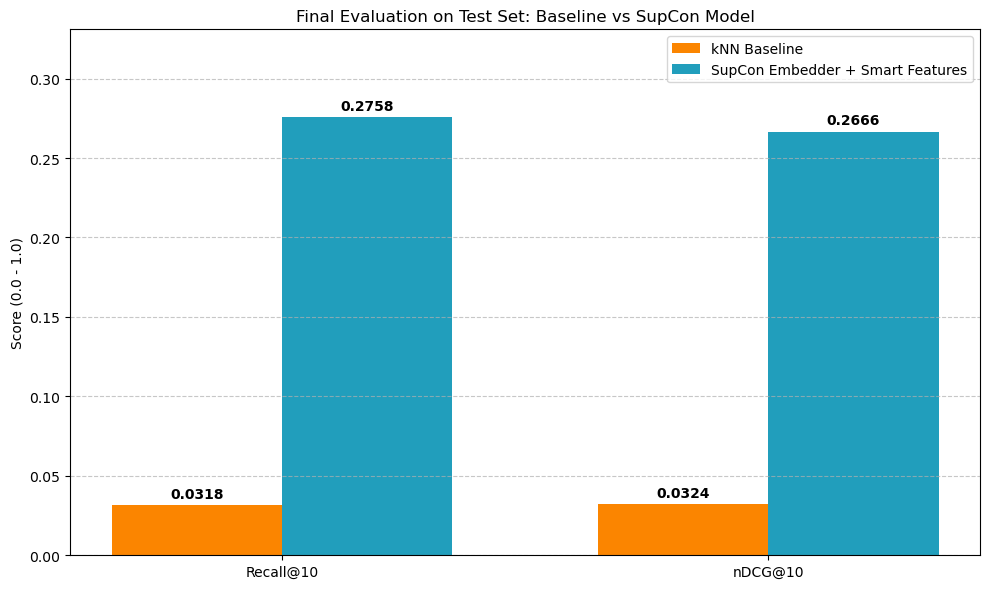

In [20]:
metrics = ['Recall@10', 'nDCG@10']
baseline_vals = [test_baseline_recall, test_baseline_ndcg]
model_vals = [test_model_recall, test_model_ndcg]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Отрисовка баров
rects1 = ax.bar(x - width/2, baseline_vals, width, label='kNN Baseline', color='#fb8500')
# Обновили название в легенде на SupCon Embedder
rects2 = ax.bar(x + width/2, model_vals, width, label='SupCon Embedder + Smart Features', color='#219ebc')

# Оформление осей и заголовка
ax.set_ylabel('Score (0.0 - 1.0)')
ax.set_title('Final Evaluation on Test Set: Baseline vs SupCon Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, max(max(baseline_vals), max(model_vals)) * 1.2) # Немного запаса сверху для текста
ax.legend()

# Функция для добавления числовых значений над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()